# Part 1: Data Loading and Aggregation

In this part, we will load population data and keyword data, clean and aggregate them to prepare for further analysis.


In [1]:
import pandas as pd
import glob
import os

# Function to clean and load a keyword CSV file
def load_clean_csv(file_path):
    df = pd.read_csv(file_path, skiprows=2, encoding='latin1')
    keyword = os.path.splitext(os.path.basename(file_path))[0]
    df.columns = ['Country', keyword]
    return df

# Load population data with specified encoding
population_df = pd.read_csv('country_population.csv', encoding='latin1')

# Load and clean all keyword CSV files for multiple years
keyword_files = glob.glob('Keywords/*.csv')
keyword_data = [load_clean_csv(file) for file in keyword_files]

# Merge all keyword DataFrames on 'Country' to ensure proper alignment
all_keywords_df = keyword_data[0]
for df in keyword_data[1:]:
    all_keywords_df = pd.merge(all_keywords_df, df, on='Country', how='outer')

# Check if data from all files are combined correctly
print(all_keywords_df.head())

# Sum up or average keyword values over the years for each country
aggregated_df = all_keywords_df.groupby('Country').sum().reset_index()

# Merge keyword data with population data
merged_df = pd.merge(aggregated_df, population_df, on='Country', how='outer')

# Remove rows with missing population data
merged_df.dropna(subset=['population'], inplace=True)

# Convert population column to numeric
merged_df['population'] = pd.to_numeric(merged_df['population'], errors='coerce').fillna(0)


          Country  asylum border crossing citizenship emigrate expatriate  \
0      Montserrat     NaN             NaN         NaN      NaN        NaN   
1  United Kingdom   100.0               4          35       57         <1   
2         Ireland    93.0               4          51       53         <1   
3          Cyprus    90.0              31         NaN      NaN        NaN   
4           Ghana    84.0             NaN          42      NaN          3   

  foreign worker green card immigrate immigration  migrate move abroad  \
0            NaN        NaN       NaN         NaN      NaN         NaN   
1             <1          5        13           6     12.0         100   
2             <1          5        12           6     11.0          68   
3            NaN        NaN       NaN          10      NaN          28   
4              4          8        27          30     15.0          12   

  permanent residency refugee  relocation visa application work permit  
0                 N

# Part 2: Data Normalization and Calculation

In this part, we will normalize the keyword values by population and calculate the Total_per_capita score for each country.


In [2]:
# Normalize the values by population and add a Value_per_capita column for each keyword
for column in merged_df.columns[1:-1]:
    if column != 'population':
        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce').fillna(0)
        merged_df[column + '_per_capita'] = merged_df[column] / merged_df['population']

# Aggregate the data by summing the normalized values for each country
aggregated_columns = [col for col in merged_df.columns if col.endswith('_per_capita')]
merged_df['Total_per_capita'] = merged_df[aggregated_columns].sum(axis=1)

# Select relevant columns for the final output
final_columns = ['Country'] + [col for col in merged_df.columns if not col.endswith('_per_capita')] + ['Total_per_capita']
final_df = merged_df[final_columns]

# Remove any duplicated 'Country' column
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Sort the countries by Total_per_capita in descending order
final_df.sort_values(by='Total_per_capita', ascending=False, inplace=True)

# Set display float format to avoid scientific notation
pd.options.display.float_format = '{:.18f}'.format

# Display the resulting dataframe
print(final_df)

# Save the result to a CSV file with formatted numbers
final_df.to_csv('country_interest_in_immigration.csv', index=False, float_format='%.18f')

print("Processed data saved to 'country_interest_in_immigration.csv'")


            Country                asylum       border crossing  \
204      St. Helena  0.000000000000000000  0.000000000000000000   
41   Cayman Islands  0.000000000000000000  0.000000000000000000   
74             Fiji  0.000000000000000000  0.000000000000000000   
133        Maldives  0.000000000000000000  0.000000000000000000   
57           Cyprus 90.000000000000000000 31.000000000000000000   
..              ...                   ...                   ...   
112          Jersey  0.000000000000000000  0.000000000000000000   
116        Kiribati  0.000000000000000000  0.000000000000000000   
117          Kosovo  0.000000000000000000  0.000000000000000000   
120            Laos  0.000000000000000000  0.000000000000000000   
249  Ãland Islands  0.000000000000000000  0.000000000000000000   

             citizenship             emigrate           expatriate  \
204 0.000000000000000000 0.000000000000000000 0.000000000000000000   
41  0.000000000000000000 0.000000000000000000 0.0000000

# Part 3: Visualization - Map

In this part, we will visualize the normalized scores on a world map.


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Read the CSV file
data = pd.read_csv('country_interest_in_immigration.csv')

# Verify the CSV file
print(data.head())
print(data.tail())

# Step 2: Remove the last row ("Total_per_capita") from the data
data = data.iloc[:-1]

# Step 3: Calculate Total Score for each country (assuming columns from 1 to the second last one are the scores)
data['Total_Score'] = data.iloc[:, 1:-1].sum(axis=1)

# Step 4: Normalize the Total_Score
scaler = MinMaxScaler()
data['Normalized_Score'] = scaler.fit_transform(data[['Total_Score']])

# Verify the new column
print(data[['Country', 'Total_Score', 'Normalized_Score']].head())

# Step 5: Read the shapefile
shapefile_path = '110m_cultural/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Verify the shapefile data
print(world.head())

# Step 6: Merge the data with the world map
world = world.merge(data, how='left', left_on='NAME', right_on='Country')


          Country                asylum       border crossing  \
0      St. Helena  0.000000000000000000  0.000000000000000000   
1  Cayman Islands  0.000000000000000000  0.000000000000000000   
2            Fiji  0.000000000000000000  0.000000000000000000   
3        Maldives  0.000000000000000000  0.000000000000000000   
4          Cyprus 90.000000000000000000 31.000000000000000000   

           citizenship             emigrate           expatriate  \
0 0.000000000000000000 0.000000000000000000 0.000000000000000000   
1 0.000000000000000000 0.000000000000000000 0.000000000000000000   
2 0.000000000000000000 0.000000000000000000 0.000000000000000000   
3 0.000000000000000000 0.000000000000000000 8.000000000000000000   
4 0.000000000000000000 0.000000000000000000 0.000000000000000000   

        foreign worker           green card            immigrate  \
0 0.000000000000000000 0.000000000000000000 0.000000000000000000   
1 0.000000000000000000 0.000000000000000000 0.000000000000000000

# Part 4: Visualization - Plotting

In this part, we will plot the map with normalized scores and create bar and pie charts for the top 10 countries.


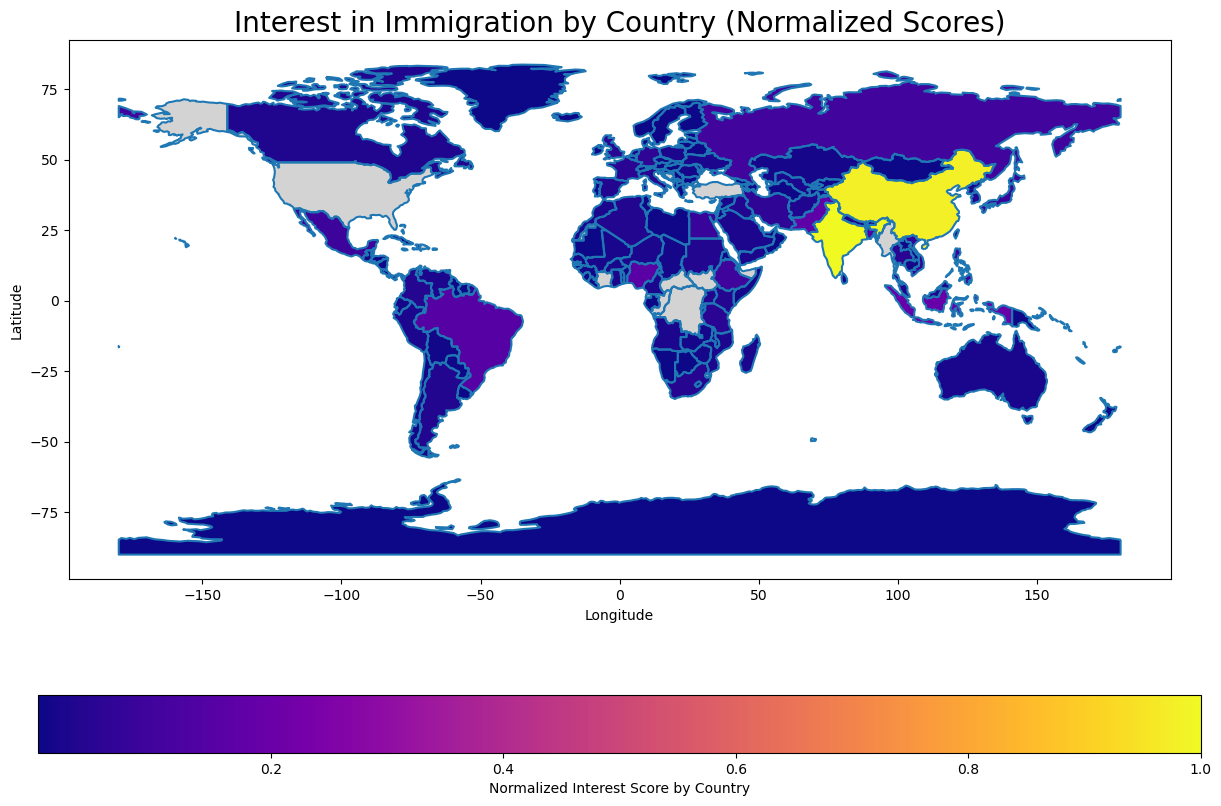

In [4]:
# Step 7: Plotting the map with normalized scores
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='Normalized_Score', ax=ax, legend=True,
           legend_kwds={'label': "Normalized Interest Score by Country",
                        'orientation': "horizontal"},
           cmap='plasma', missing_kwds={"color": "lightgrey"})

# Add title and labels
ax.set_title('Interest in Immigration by Country (Normalized Scores)', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Save the plot as an image file
plt.savefig('interest_in_immigration_map_normalized.png', dpi=300)
plt.show()


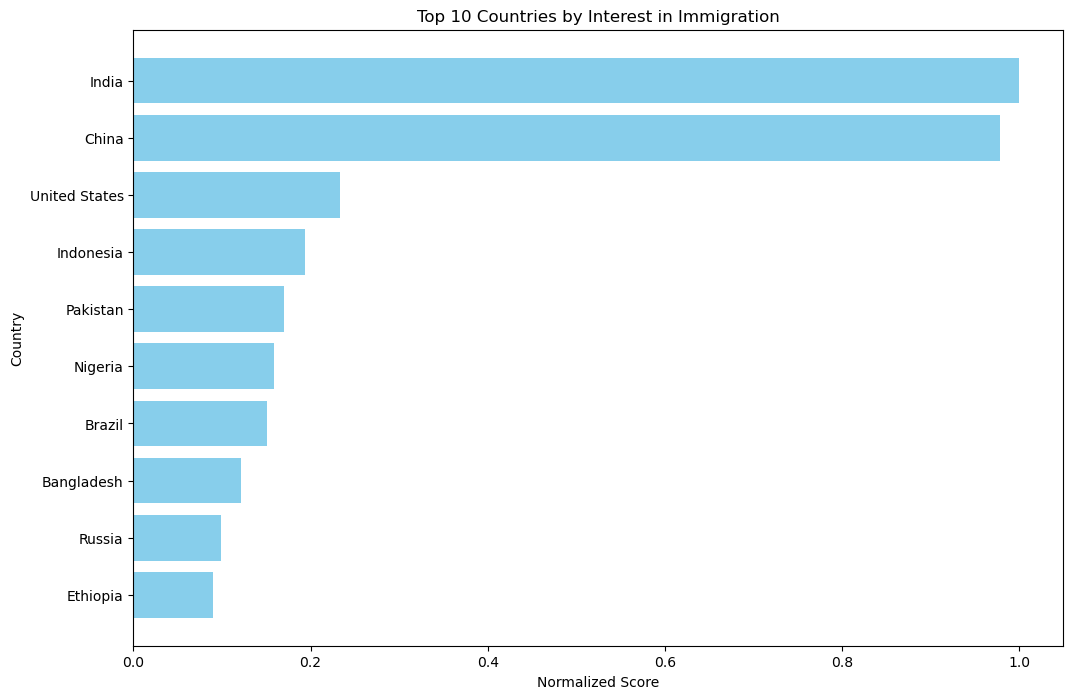

In [5]:
# Step 8: Top 10 Countries Bar Chart
top_10_countries = data.nlargest(10, 'Normalized_Score')
plt.figure(figsize=(12, 8))
plt.barh(top_10_countries['Country'], top_10_countries['Normalized_Score'], color='skyblue')
plt.xlabel('Normalized Score')
plt.ylabel('Country')
plt.title('Top 10 Countries by Interest in Immigration')
plt.gca().invert_yaxis()
plt.savefig('top_10_countries_bar_chart.png', dpi=300)
plt.show()


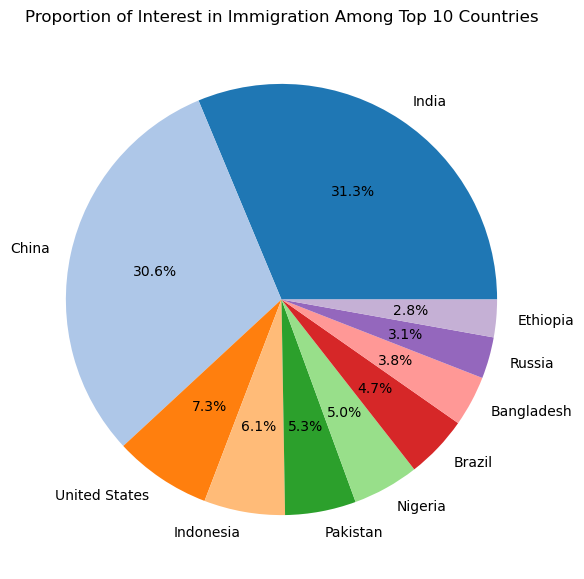

In [6]:
# Step 9: Pie Chart of Top 10 Countries
plt.figure(figsize=(10, 7))
plt.pie(top_10_countries['Normalized_Score'], labels=top_10_countries['Country'], autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Proportion of Interest in Immigration Among Top 10 Countries')
plt.savefig('top_10_countries_pie_chart.png', dpi=300)
plt.show()


# Part 5: Detailed Statistics

In this part, we will display detailed statistics for the top 10 countries by interest in immigration.


In [7]:
# Step 10: Detailed Statistics
print("Top 10 Countries by Interest in Immigration:")
print(top_10_countries[['Country', 'Normalized_Score']])


Top 10 Countries by Interest in Immigration:
           Country     Normalized_Score
107          India 1.000000000000000000
108          China 0.978090307557120009
82   United States 0.233478722224311236
111      Indonesia 0.194072408641488420
85        Pakistan 0.170081576951791436
69         Nigeria 0.158943948007922553
112         Brazil 0.150956713810200094
84      Bangladesh 0.121175646007770754
105         Russia 0.099448479996216518
68        Ethiopia 0.089975847070950313
